In [ ]:
import numpy as np
import hw6_utils
from hw6_utils import load_MNIST

np.random.seed(2024)

batch_size = 32

normalize_vals = (0.1307, 0.3081)

# load MNIST dataset
train_dataset, test_dataset, train_loader, test_loader = load_MNIST(batch_size, normalize_vals)

**Build CNN**

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 20, kernel_size = 3, stride = 1, dilation = 1, bias = True) # convolution layer
    self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2) # max pooling
    self.dropout = nn.Dropout(p = 0.5) # dropout layer

    self.fc1 = nn.Linear(in_features = 20 * 13 * 13, out_features = 128) # fully connected layer 1
    self.fc2 = nn.Linear(in_features = 128, out_features = 10) # fully connected layer 2

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x))) # apply convolution, relu, pool
    x = self.dropout(x) # apply dropout
    x = torch.flatten(x, 1) # flatten
    x = F.relu(self.fc1(x)) # apply relu to fully connected layer 1
    x = self.dropout(x) # apply dropout again
    x = self.fc2(x) # apply relu to fully connected layer 2
    return x

net = Net()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters())

for epoch in range(8):

  # training phase
  net.train()

  # initialize summary statistics
  running_train_loss = 0.0
  correct_train_predictions = 0
  total_train_predictions = 0

  # loop through training data
  for i, data in enumerate(train_loader, 0):

    # get the inputs
    inputs, labels = data

    # zero out the parameter gradients
    optimizer.zero_grad()

    # forward, backward, and then optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # accumulate info to summary statistics
    running_train_loss += loss.item()
    _, predicted = torch.max(outputs.data, 1)
    total_train_predictions += labels.size(0)
    correct_train_predictions += (predicted == labels).sum().item()

    train_loss = running_train_loss / len(train_loader)
    train_error = 1 - correct_train_predictions / total_train_predictions

    # evaluation phase
    net.eval()

    # initialize summary statistics
    running_test_loss = 0.0
    correct_test_predictions = 0
    total_test_predictions = 0

  # compute test predictions
  with torch.no_grad():
    for data in test_loader:
      images, labels = data
      outputs = net(images)
      loss = criterion(outputs, labels)
      running_test_loss += loss.item()
      _, predicted = torch.max(outputs.data, 1)
      total_test_predictions += labels.size(0)
      correct_test_predictions += (predicted == labels).sum().item()

  test_loss = running_test_loss / len(test_loader)
  test_error = 1 - correct_test_predictions / total_test_predictions

  # print summary statistics
  print(f'Epoch: {epoch}')
  print(f'Train Loss: {train_loss}')
  print(f'Train Error: {train_error}')
  print(f'Test Loss: {test_loss}')
  print(f'Test Error: {test_error}')



print('Finished Training')

PATH = './mnist_net.pth'
torch.save(net.state_dict(), PATH)

Epoch: 0
Train Loss: 0.9235468217730523
Train Error: 0.20299999999999996
Test Loss: 0.40809471160173416
Test Error: 0.10909999999999997
Epoch: 1
Train Loss: 0.3643887309273084
Train Error: 0.10124999999999995
Test Loss: 0.3083455439347524
Test Error: 0.08630000000000004
Epoch: 2
Train Loss: 0.3026581007540226
Train Error: 0.0869833333333333
Test Loss: 0.26953066606967213
Test Error: 0.0776
Epoch: 3
Train Loss: 0.2689956039249897
Train Error: 0.07796666666666663
Test Loss: 0.24321220117136122
Test Error: 0.07099999999999995
Epoch: 4
Train Loss: 0.2439123853156964
Train Error: 0.0702166666666667
Test Loss: 0.22231752265054291
Test Error: 0.0655
Epoch: 5
Train Loss: 0.22316654348274073
Train Error: 0.06398333333333328
Test Loss: 0.20453669005832353
Test Error: 0.06000000000000005
Epoch: 6
Train Loss: 0.20544747035553057
Train Error: 0.05864999999999998
Test Loss: 0.1891803349808644
Test Error: 0.05449999999999999
Epoch: 7
Train Loss: 0.18986423053046067
Train Error: 0.054200000000000026
T

In [ ]:
# see how the network performs on the test set
correct = 0
total = 0

with torch.no_grad():
  for data in test_loader:
    images, labels = data

    # calculate outputs by running images through the network
    outputs = net(images)

    # the class with the highest energy is the prediction
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f"Accuracy of the network: {correct / total}")

Accuracy of the network: 0.9497


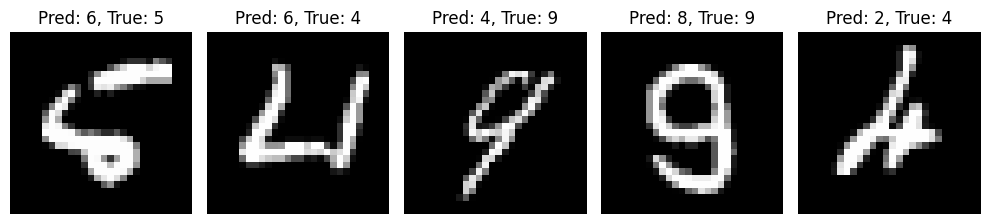

In [ ]:
import matplotlib.pyplot as plt

# track misclassified images
misclassified = []
max_to_show = 5

for inputs, labels in test_loader:
    # get predictions from the model
    outputs = net(inputs)
    _, predicted = torch.max(outputs, 1)

    # find misclassified indices
    misclass_indices = (predicted != labels).nonzero(as_tuple=True)[0]

    # collect misclassified images and their details
    for idx in misclass_indices:
        if len(misclassified) < max_to_show:
            misclassified.append((inputs[idx], predicted[idx], labels[idx]))
        else:
            break

    if len(misclassified) >= max_to_show:
        break

# plot the misclassified images
plt.figure(figsize=(10, 10))
for i, (image, pred, true) in enumerate(misclassified):
    plt.subplot(1, len(misclassified), i + 1)
    # Convert the tensor to a numpy array if needed
    plt.imshow(image.permute(1, 2, 0).cpu().numpy(), cmap="gray")  # Assumes channel-first
    plt.title(f"Pred: {pred.item()}, True: {true.item()}")
    plt.axis("off")
plt.tight_layout()
plt.show()


To begin building the CNN, we had to load in the MNIST data using the given helper function and we chose an arbitrary batch size and made sure that the values were normalized. Normalizing the data doesn't allow for any of the pixels in the image to have a value outside of the range [0,1].

Following the characteristics of building the network, we were able to build the framework for the net and move onto the training phase. I decided to choose 8 epochs because the change in loss was decreasing much slower while the accuracy was also improving by the time we had hit the final epoch. I also tried 10-15 epochs as well, but felt like the change was too small and could lead to overfitting in the end. For each epoch, we could see the summary statistics of train/test loss and train/test accuracy to get a feel for how our model was fitting the data. To get these statistics, we had to zero out the gradients, use cross entropy to compute the loss, backpropagate, and finally use stochastic gradient descent to optimize the network. The accuracy for our network was pretty high at about 95%.

Despite our modeling having a really high accuracy, there were some misclassifications as expected. Let's dive into why the network may have made incorrect predictions for each image.

Image 1: This is a poorly written digit and could go either way. If the lines were connected at the top like they should be, I would have thought it was a six as well.

Image 2: I am not sure why the model predicted a six here, this image doesn't share many similarities and characteristics of a six.

Image 3: With the top of the digit not being connected, this could easily have looked like a four to the model. The human eye would call that a nine, but again not a poor error.

Image 4: This is a really poor nine as it shares a lot of characteristics that an eight should have. The lines are almost fully connected with the two loops that an eight would have. Not a bad miss here either.

Image 5: I am assuming multiple classes had pretty even probabilities here as this digit doesn't seem to have correlation with any digit from the human eye.

Overall, the models performance was really good at almost 95%. After analyzing some of the misclassifications a lot of them would have been really tough for the model to pick up and the model did a good job of getting as close as possible with near misses (classifying a four as a nine).

---